# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [1]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import jax.numpy as jnp
import jax

In [2]:
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr]).T

def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'bo')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'r->')
    
    plt.show()
    
    
def readEdge_odom(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))
        if "FIX" in line:
            break

    return (jnp.array(ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta)) 

def readEdge_lc(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()
    flag=0
    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "FIX" in line:
            flag=1
        if flag==1:    
            if "EDGE_SE2" in line:
                    (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
                    ind1_arr.append(int(ind1))
                    ind2_arr.append(int(ind2))
                    del_x.append(float(dx))
                    del_y.append(float(dy))
                    del_theta.append(float(dtheta))

    return (jnp.array(ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta)) 


In [3]:
edges = readEdge_odom("../data/edges.txt")
edges_lc = readEdge_lc("../data/edges.txt")
prior = readVertex("../data/edges.txt")

In [4]:
def pose_estimate(prior, edges):
    [in1_edge,in2_edge,X_edge,Y_edge,Theta_edge] = edges
    X,Y,Theta = [prior[0][0]],[prior[0][1]],[prior[0][2]]
    
    for i in in1_edge:
        delta_X = X_edge[i]
        delta_Y = Y_edge[i]
        
        pose_j = get_pose(X[i], Y[i], Theta[i], delta_X, delta_Y, Theta_edge[i])
        X.append(pose_j[0])
        Y.append(pose_j[1])
        Theta.append(pose_j[2])
        
    return jnp.array([X,Y,Theta]).T

def get_pose(x, y, theta, del_x, del_y, del_theta):
    return jnp.array([x + del_x * jnp.cos(theta) - del_y * jnp.sin(theta), 
                      y + del_x * jnp.sin(theta) + del_y * jnp.cos(theta),
                      theta + del_theta])

(120, 3)


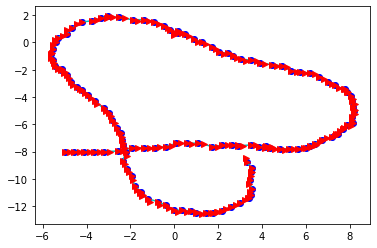

In [5]:
poses = pose_estimate(prior, edges)
print(poses.shape)
draw(poses[:, 0], poses[:, 1], poses[:, 2])

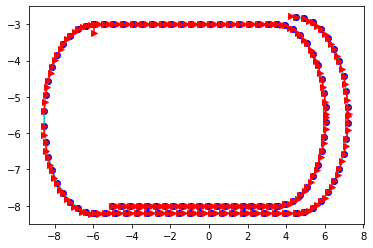

In [6]:
poses_gt = readVertex("../data/gt.txt")
draw(poses_gt[:,0], poses_gt[:,1], poses_gt[:,2])

In [7]:
def save_g2o_from_edges_init(fromfileName, tofilename, poses):
#     poses = pose_estimate(prior,edges)
    X,Y,Theta = poses[:,0], poses[:,1], poses[:,2]
    f = open(fromfileName, 'r')
    A = f.readlines()
    f.close()
    with open(tofilename, "w") as g2o_file:
        for i,x,y,theta in zip(range(len(X)),X,Y,Theta):
            g2o_file.write("VERTEX_SE2 "+str(i)+" "+str(x)+" "+str(y)+" "+str(theta)+"\n")
        for line in A:
            if "VERTEX_SE2" in line:
                continue
            g2o_file.write(line)    
            
def save_g2o(fromfileName, tofilename):
    f = open(fromfileName, 'r')
    A = f.readlines()
    f.close()
    with open(tofilename, "w") as g2o_file:
        for line in A:
            g2o_file.write(line)    

In [8]:
save_g2o_from_edges_init("../data/edges.txt","../data/edges-poses.g2o", poses)
save_g2o("../data/gt.txt","../data/gt.g2o")

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [9]:
print(len(edges[0]), len(edges_lc[0]))

119 20


In [10]:
def draw_together(poses_gt, poses_noisy, poses_opt):
    ax = plt.subplot(111)
    X1, Y1, T1 = poses_gt[:,0], poses_gt[:,1], poses_gt[:,2]
    ax.plot(X1, Y1, 'bo')
    plt.plot(X1, Y1, 'c-')

    for i in range(len(X1)):
        x1 = 0.25*math.cos(T1[i]) + X1[i]
        y1 = 0.25*math.sin(T1[i]) + Y1[i]
        plt.plot([X1[i], x1], [Y1[i], y1], 'r->')
    gt_label = mpatches.Patch(color='red', label='Ground Truth')
        
    X2, Y2, T2 = poses_noisy[:,0], poses_noisy[:,1], poses_noisy[:,2]
    ax.plot(X2, Y2, 'bo')
    plt.plot(X2, Y2, 'c-')
    
    for i in range(len(X2)):
        x2 = 0.25*math.cos(T2[i]) + X2[i]
        y2 = 0.25*math.sin(T2[i]) + Y2[i]
        plt.plot([X2[i], x2], [Y2[i], y2], 'g->')
    noisy_legend = mpatches.Patch(color='green', label='Noisy')
        
    X3, Y3, T3 = poses_opt[:,0], poses_opt[:,1], poses_opt[:,2]
    ax.plot(X3, Y3, 'bo')
    plt.plot(X3, Y3, 'c-')    
    for i in range(len(X3)):    
        x3 = 0.25*math.cos(T3[i]) + X3[i]
        y3 = 0.25*math.sin(T3[i]) + Y3[i]
        plt.plot([X3[i], x3], [Y3[i], y3], 'b->')
    opt_legend = mpatches.Patch(color='blue', label='Optimised')  
    
    plt.legend(handles=[gt_label, noisy_legend, opt_legend])
    plt.show()

In [11]:
def get_f(poses, edges, edges_lc, prior):
#     get_pose(x, y, theta, del_x, del_y, del_theta)
    f = []
    X,Y,Theta = poses[:,0], poses[:,1], poses[:,2]
    
    for i in range(len(edges[0])):
        a = edges[0][i]
        b = edges[1][i]
        pose = get_pose(X[a], Y[a], Theta[a], edges[2][i], edges[3][i], edges[4][i])
        f.append(pose[0] - X[b])
        f.append(pose[1] - Y[b])
        f.append(pose[2] - Theta[b])
        
    for i in range(len(edges_lc[0])):
        a = edges_lc[0][i]
        b = edges_lc[1][i]
        pose = get_pose(X[a], Y[a], Theta[a], edges_lc[2][i], edges_lc[3][i], edges_lc[4][i])
        f.append(pose[0] - X[b])
        f.append(pose[1] - Y[b])
        f.append(pose[2] - Theta[b])
        
    f.append(X[0] - prior[0][0])
    f.append(Y[0] - prior[0][1])
    f.append(Theta[0] - prior[0][2])
    
    return jnp.array([f]).T

In [12]:
# get_f(poses, edges, edges_lc, prior)

In [13]:
def frobNorm(M1, M2):
    return jnp.linalg.norm(M1 - M2, 'fro')

In [14]:
def Jacobian(poses, edges, edges_lc):
    Jr = -jnp.identity(3)
    
    h = 3 * (len(edges[0]) + len(edges_lc[0]) + 1)
    w = 3 * (len(edges[0]) + 1)
    J = jnp.zeros((h,w))
    
    for i in range(len(edges[0])):
        index_y = 3 * i
        index_x_s = 3 * edges[0][i]
        index_x_r = 3 * edges[1][i]
        theta = poses[edges[0][i], 2]
        
        Js = single_Jacobian(edges[2][i], edges[3][i], theta)
        J = set_J(J, index_y, index_x_s, Js)
        J = set_J(J, index_y, index_x_r, Jr)
        
    start_ind = 3 * len(edges[0])
    
    for i in range(len(edges_lc[0])):
        index_y = start_ind + 3 * i
        index_x_s = 3 * edges_lc[0][i]
        index_x_r = 3 * edges_lc[1][i]
        theta = poses[edges_lc[0][i], 2]
        
        Js = single_Jacobian(edges_lc[2][i], edges_lc[3][i], theta)
        J = set_J(J, index_y, index_x_s, Js)
        J = set_J(J, index_y, index_x_r, Jr)
    
    prior_index_y = 3 * (len(edges[0]) + len(edges_lc[0]))
    J = set_J(J, prior_index_y, 0, jnp.identity(3))
    
    return J
        
def single_Jacobian(del_x, del_y, theta):
    return jnp.array([[1, 0, - del_x * jnp.sin(theta) - del_y * jnp.cos(theta)],
                      [0, 1, del_x * jnp.cos(theta) - del_y * jnp.sin(theta)],
                      [0, 0, 1]])

def set_J(J, h, w, matrix):
    return jax.ops.index_update(J, jax.ops.index[h:h+3, w:w+3], matrix)

In [15]:
jacob = jax.jacfwd(get_f)
J_verify = jacob(poses, edges, edges_lc, prior)
J_verify = J_verify.reshape(420,120,3).reshape((420, 360, 1))[:, :, 0]

In [16]:
# np.arange(12).reshape(4,3).reshape(4,-1, 1)

In [17]:
edges = readEdge_odom("../data/edges.txt")
edges_lc = readEdge_lc("../data/edges.txt")

J = Jacobian(poses, edges, edges_lc)

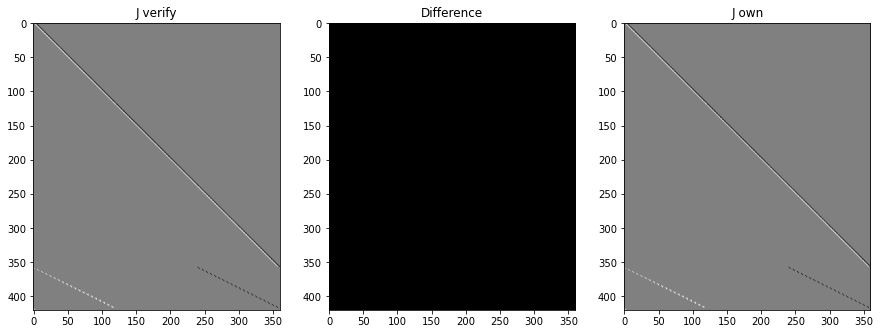

In [18]:
fig, axis = plt.subplots(1,3, figsize = (15, 10))
axis[0].imshow(J_verify, cmap = "gray")
axis[0].set_title("J verify")
# axis[0].set_xticks(jnp.arange())

axis[1].imshow(J_verify - J, cmap = "gray")
axis[1].set_title("Difference")

axis[2].imshow(J, cmap = "gray")
axis[2].set_title("J own")
plt.show()
# J_verify.shape

In [19]:
print("The frobenius norm of difference of J and J_verify is", frobNorm(J, J_verify))

The frobenius norm of difference of J and J_verify is 0.0


In [20]:
# # a = jnp.arange(12).reshape(4,3)
# a = jnp.array([[1, 5, 7], [3, 6, 8], [2, 4, 10], [13, 15, 19]])
# a = a.reshape(12,1)
# a.reshape(4,3)

In [21]:
poses = pose_estimate(prior, edges)

In [22]:
# poses_vector = poses.reshape(poses.shape[0]*poses.shape[1], 1)
# get_f(poses_vector, edges, edges_lc, prior)
# poses_vector[0::3][:,0]

In [23]:
def get_error(f, phi):
    return jnp.dot(f.T, jnp.dot(phi, f))[0,0] / 2

In [24]:
def info_matrix(count_edges, count_edges_lc, info_odom, info_lc, info_prior):
    info_diag = [info_odom] * (3 * count_edges)
    info_diag.extend([info_lc] * (3 * count_edges_lc))
    info_diag.extend([info_prior] * 3)
    return jnp.diag(jnp.array(info_diag))

In [25]:
phi = info_matrix(len(edges[0]), len(edges_lc[0]), 500, 700, 1000)
print(phi)
print(phi.shape)

[[ 500    0    0 ...    0    0    0]
 [   0  500    0 ...    0    0    0]
 [   0    0  500 ...    0    0    0]
 ...
 [   0    0    0 ... 1000    0    0]
 [   0    0    0 ...    0 1000    0]
 [   0    0    0 ...    0    0 1000]]
(420, 420)


In [26]:
poses_gt = readVertex("../data/gt.txt")

In [27]:
# LM -> 
# (H + lambda * I) = - b, where b = b_const * f(x)
# 

def Levenberg_Marquardt(edges, edges_lc, poses_initial, prior, num_iters, lambda_, infos, poses_gt = poses_gt, tol = 1e-20, plot_error = False):
    J = Jacobian(poses_initial, edges, edges_lc)
    phi = info_matrix(len(edges[0]), len(edges_lc[0]), infos[0], infos[1], infos[2])
    
    m,n = poses_initial.shape[0], poses_initial.shape[1]
    poses_vector = poses_initial.reshape(m*n, 1)
    
    H = jnp.dot(J.T, jnp.dot(phi, J))
    I = jnp.identity(H.shape[0])
    H_I = H + lambda_ * I
    H_I_inv = jnp.linalg.inv(H_I)
    
    b_const = jnp.dot(J.T, phi.T)
    
    Hb = jnp.dot(H_I_inv, b_const)
#     print(Hb.shape)
#     print(get_f(poses_vector, edges, edges_lc).shape)
    
    last_error = 0
        
    if plot_error:
        errors = []
    
    for i in range(num_iters):
        poses_o = poses_vector.reshape(m,n)
        f = get_f(poses_o, edges, edges_lc, prior)

        delta_poses = -jnp.dot(Hb, f)
        
        error = get_error(f, phi)
        print(f"Iteration = {i}, Error = {error}")
        if plot_error:
            errors.append(error)
            
        if i > 0:
            if (error > last_error):
                lambda_ *= 2
            else:
                lambda_ /= 3
                
            H_I = H + lambda_ * I
            H_I_inv = jnp.linalg.inv(H_I)
    
            Hb = jnp.dot(H_I_inv, b_const)
        
        if i % 10 == 0:
            draw_together(poses_gt, poses_initial, poses_o)
        
        last_error = error
        
        if (jnp.abs(delta_poses) < tol).all():
#             print(i)
            break
            
        poses_vector += delta_poses
        
    if plot_error:
        plot_x = jnp.arange(len(errors))
        plt.plot(plot_x, errors)
#         plt.xticks(plot_x)
        plt.xlabel("Iterations")
        plt.ylabel("Error")
        plt.show()
    
    poses_o = poses_vector.reshape(m,n)
    print("Finally")
    draw_together(poses_gt, poses_initial, poses_o)
    return poses_o

<a id='Optimization'></a>

Iteration = 0, Error = 639372.0


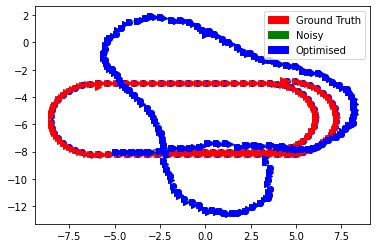

Iteration = 1, Error = 90723.453125
Iteration = 2, Error = 9582.1064453125
Iteration = 3, Error = 6663.4150390625
Iteration = 4, Error = 5897.8056640625
Iteration = 5, Error = 3169.246826171875
Iteration = 6, Error = 1939.8447265625
Iteration = 7, Error = 1913.7154541015625
Iteration = 8, Error = 2097.580078125
Iteration = 9, Error = 1771.926513671875
Iteration = 10, Error = 1213.5556640625


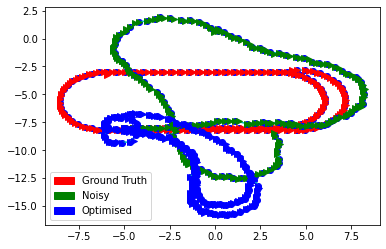

Iteration = 11, Error = 910.5226440429688
Iteration = 12, Error = 791.1915283203125
Iteration = 13, Error = 740.9365844726562
Iteration = 14, Error = 717.284423828125
Iteration = 15, Error = 705.3968505859375
Iteration = 16, Error = 698.7861938476562
Iteration = 17, Error = 693.7850952148438
Iteration = 18, Error = 688.0652465820312
Iteration = 19, Error = 680.3645629882812
Iteration = 20, Error = 670.5582275390625


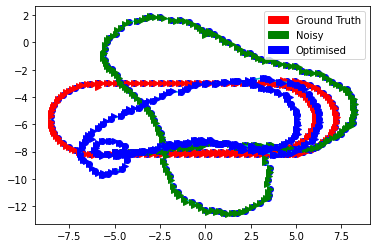

Iteration = 21, Error = 659.5938110351562
Iteration = 22, Error = 649.0050659179688
Iteration = 23, Error = 640.15234375
Iteration = 24, Error = 633.7022094726562
Iteration = 25, Error = 629.7352905273438
Iteration = 26, Error = 628.2195434570312
Iteration = 27, Error = 629.1405029296875
Iteration = 28, Error = 632.0271606445312
Iteration = 29, Error = 635.425048828125
Iteration = 30, Error = 637.1652221679688


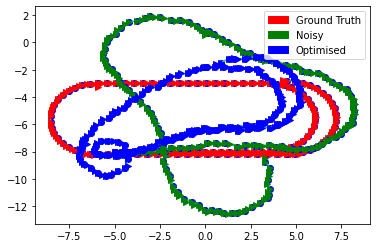

Iteration = 31, Error = 635.64306640625
Iteration = 32, Error = 631.1452026367188
Iteration = 33, Error = 625.56298828125
Iteration = 34, Error = 620.3429565429688
Iteration = 35, Error = 615.4645385742188
Iteration = 36, Error = 611.7077026367188
Iteration = 37, Error = 613.1658935546875
Iteration = 38, Error = 625.0841674804688
Iteration = 39, Error = 647.6270141601562
Iteration = 40, Error = 671.431396484375


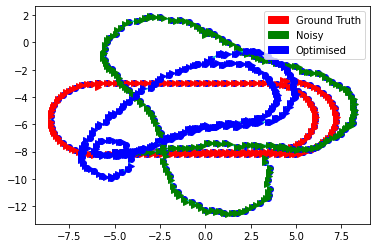

Iteration = 41, Error = 681.3895874023438
Iteration = 42, Error = 671.610595703125
Iteration = 43, Error = 659.5680541992188
Iteration = 44, Error = 667.5462036132812
Iteration = 45, Error = 679.17529296875
Iteration = 46, Error = 657.8821411132812
Iteration = 47, Error = 620.0303344726562
Iteration = 48, Error = 635.0252685546875
Iteration = 49, Error = 761.48095703125
Iteration = 50, Error = 1003.300048828125


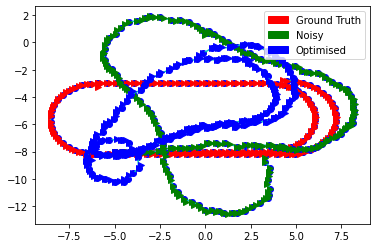

Iteration = 51, Error = 1273.635498046875
Iteration = 52, Error = 1355.8414306640625
Iteration = 53, Error = 1123.0975341796875
Iteration = 54, Error = 1200.911865234375
Iteration = 55, Error = 2054.146484375
Iteration = 56, Error = 2225.9091796875
Iteration = 57, Error = 1494.2122802734375
Iteration = 58, Error = 966.6168212890625
Iteration = 59, Error = 1169.234375
Iteration = 60, Error = 2306.62255859375


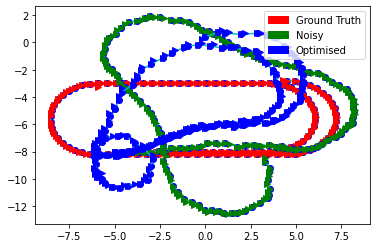

Iteration = 61, Error = 5070.310546875
Iteration = 62, Error = 10856.4296875
Iteration = 63, Error = 16957.439453125
Iteration = 64, Error = 11194.849609375
Iteration = 65, Error = 5059.42822265625
Iteration = 66, Error = 5076.24853515625
Iteration = 67, Error = 5912.38623046875
Iteration = 68, Error = 6966.26953125
Iteration = 69, Error = 8079.4189453125
Iteration = 70, Error = 5837.23681640625


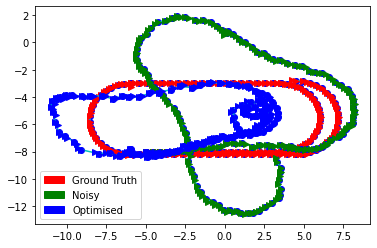

Iteration = 71, Error = 3721.047607421875
Iteration = 72, Error = 5188.591796875
Iteration = 73, Error = 4957.5517578125
Iteration = 74, Error = 3738.0712890625
Iteration = 75, Error = 2321.890380859375
Iteration = 76, Error = 1323.2393798828125
Iteration = 77, Error = 898.5682373046875
Iteration = 78, Error = 793.6887817382812
Iteration = 79, Error = 779.53955078125
Iteration = 80, Error = 779.5260009765625


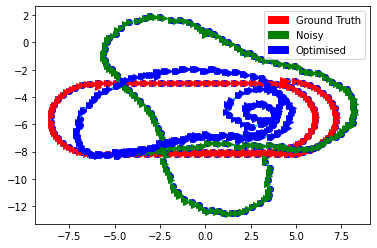

Iteration = 81, Error = 780.60205078125
Iteration = 82, Error = 781.3595581054688
Iteration = 83, Error = 781.7992553710938
Iteration = 84, Error = 782.0618896484375
Iteration = 85, Error = 782.2410278320312
Iteration = 86, Error = 782.38037109375
Iteration = 87, Error = 782.4971923828125
Iteration = 88, Error = 782.5972290039062
Iteration = 89, Error = 782.6831665039062
Iteration = 90, Error = 782.7562866210938


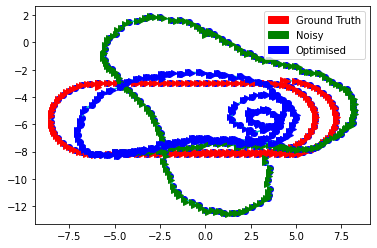

Iteration = 91, Error = 782.8179931640625
Iteration = 92, Error = 782.8697509765625
Iteration = 93, Error = 782.912353515625
Iteration = 94, Error = 782.9476928710938
Iteration = 95, Error = 782.9765014648438
Iteration = 96, Error = 783.0001831054688
Iteration = 97, Error = 783.0195922851562
Iteration = 98, Error = 783.0352783203125
Iteration = 99, Error = 783.0477905273438


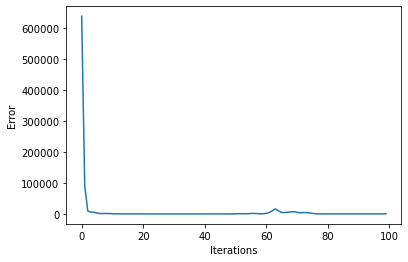

Finally


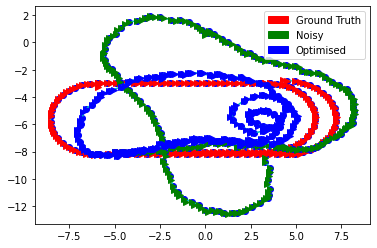

In [28]:
poses_opt = Levenberg_Marquardt(edges, edges_lc, poses, prior, 100, 1, infos = [500, 700, 1000], plot_error = True)
# poses_opt

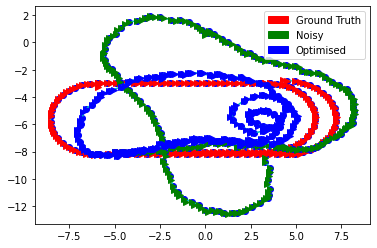

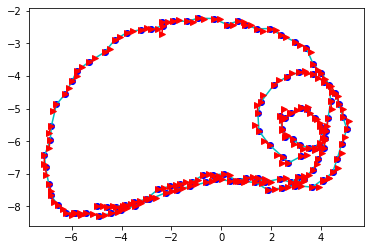

In [29]:
draw_together(poses_gt, poses, poses_opt)
draw(poses_opt[:, 0], poses_opt[:, 1], poses_opt[:, 2])

Iteration = 0, Error = 913388.625


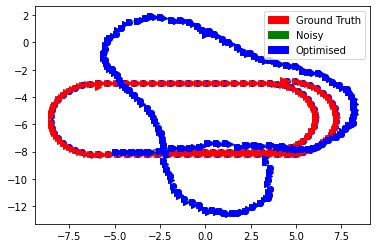

Iteration = 1, Error = 102600.4609375
Iteration = 2, Error = 5605.896484375
Iteration = 3, Error = 4822.2685546875
Iteration = 4, Error = 4587.1220703125
Iteration = 5, Error = 4589.74072265625
Iteration = 6, Error = 2263.5869140625
Iteration = 7, Error = 1945.0018310546875
Iteration = 8, Error = 1533.266845703125
Iteration = 9, Error = 1081.75390625
Iteration = 10, Error = 660.06640625


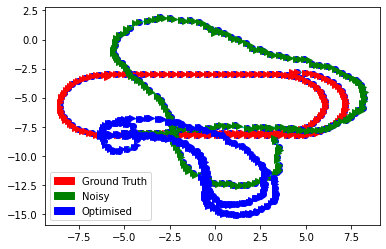

Iteration = 11, Error = 436.98602294921875
Iteration = 12, Error = 352.16937255859375
Iteration = 13, Error = 325.8066101074219
Iteration = 14, Error = 320.3284912109375
Iteration = 15, Error = 321.12255859375
Iteration = 16, Error = 322.0897521972656
Iteration = 17, Error = 320.3485412597656
Iteration = 18, Error = 314.77935791015625
Iteration = 19, Error = 305.7882385253906
Iteration = 20, Error = 295.1007080078125


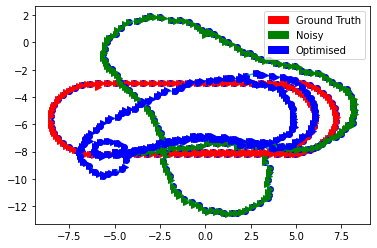

Iteration = 21, Error = 285.0188293457031
Iteration = 22, Error = 277.2823181152344
Iteration = 23, Error = 272.3691711425781
Iteration = 24, Error = 269.867431640625
Iteration = 25, Error = 269.4040832519531
Iteration = 26, Error = 270.92852783203125
Iteration = 27, Error = 274.0158386230469
Iteration = 28, Error = 277.1363220214844
Iteration = 29, Error = 278.09783935546875
Iteration = 30, Error = 275.84088134765625


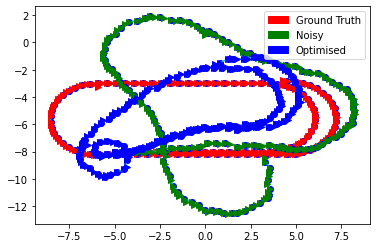

Iteration = 31, Error = 271.97076416015625
Iteration = 32, Error = 269.426513671875
Iteration = 33, Error = 268.5668640136719
Iteration = 34, Error = 266.3861083984375
Iteration = 35, Error = 262.1229248046875
Iteration = 36, Error = 261.5059509277344
Iteration = 37, Error = 271.94805908203125
Iteration = 38, Error = 293.40740966796875
Iteration = 39, Error = 313.9454650878906
Iteration = 40, Error = 316.30340576171875


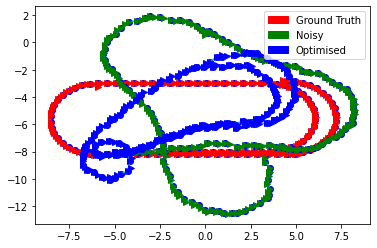

Iteration = 41, Error = 299.1922912597656
Iteration = 42, Error = 295.810791015625
Iteration = 43, Error = 335.38446044921875
Iteration = 44, Error = 369.2571716308594
Iteration = 45, Error = 334.0234375
Iteration = 46, Error = 275.9045104980469
Iteration = 47, Error = 289.05047607421875
Iteration = 48, Error = 422.7514953613281
Iteration = 49, Error = 669.1012573242188
Iteration = 50, Error = 931.9071044921875


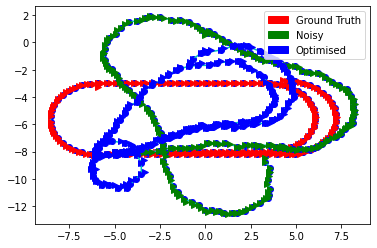

Iteration = 51, Error = 963.91162109375
Iteration = 52, Error = 607.6744995117188
Iteration = 53, Error = 721.7438354492188
Iteration = 54, Error = 2011.733154296875
Iteration = 55, Error = 2058.50390625
Iteration = 56, Error = 939.0836181640625
Iteration = 57, Error = 449.1089172363281
Iteration = 58, Error = 625.54248046875
Iteration = 59, Error = 1552.018310546875
Iteration = 60, Error = 3823.56201171875


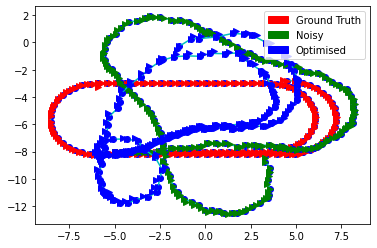

Iteration = 61, Error = 8778.59375
Iteration = 62, Error = 15345.291015625
Iteration = 63, Error = 11815.6064453125
Iteration = 64, Error = 4456.4716796875
Iteration = 65, Error = 3758.310302734375
Iteration = 66, Error = 4184.80615234375
Iteration = 67, Error = 4322.95654296875
Iteration = 68, Error = 2647.7509765625
Iteration = 69, Error = 3396.729736328125
Iteration = 70, Error = 4848.521484375


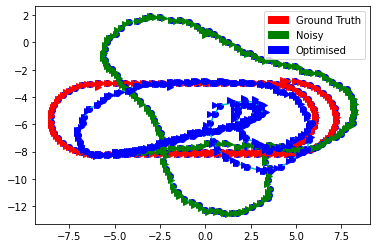

Iteration = 71, Error = 4622.98193359375
Iteration = 72, Error = 3427.4716796875
Iteration = 73, Error = 2076.9912109375
Iteration = 74, Error = 1064.035888671875
Iteration = 75, Error = 556.4736328125
Iteration = 76, Error = 385.9501037597656
Iteration = 77, Error = 343.64837646484375
Iteration = 78, Error = 334.27978515625
Iteration = 79, Error = 331.97003173828125
Iteration = 80, Error = 331.16070556640625


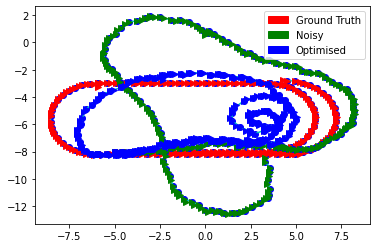

Iteration = 81, Error = 330.7244873046875
Iteration = 82, Error = 330.4372863769531
Iteration = 83, Error = 330.2439270019531
Iteration = 84, Error = 330.11669921875
Iteration = 85, Error = 330.03558349609375
Iteration = 86, Error = 329.9849853515625
Iteration = 87, Error = 329.9542236328125
Iteration = 88, Error = 329.93609619140625
Iteration = 89, Error = 329.9256286621094
Iteration = 90, Error = 329.9200134277344


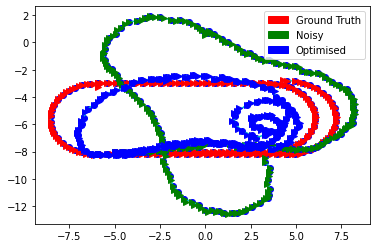

Iteration = 91, Error = 329.9171142578125
Iteration = 92, Error = 329.916015625
Iteration = 93, Error = 329.9158630371094
Iteration = 94, Error = 329.91607666015625
Iteration = 95, Error = 329.9165344238281
Iteration = 96, Error = 329.9171142578125
Iteration = 97, Error = 329.917724609375
Iteration = 98, Error = 329.91827392578125
Iteration = 99, Error = 329.9187927246094


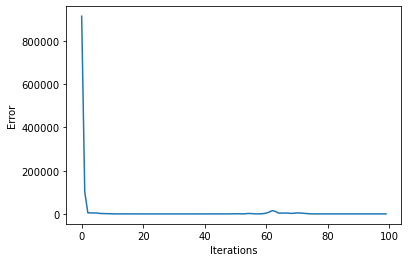

Finally


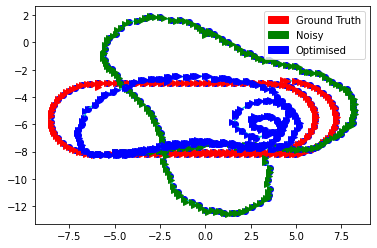

In [30]:
poses_opt = Levenberg_Marquardt(edges, edges_lc, poses, prior, 100, 1, infos = [200, 1000, 1500], plot_error = True)

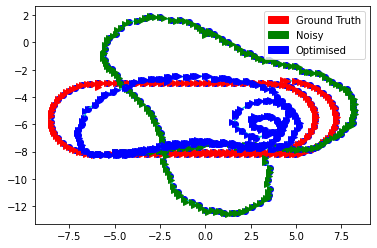

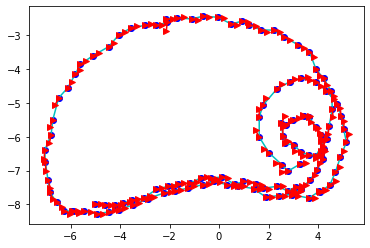

In [31]:
draw_together(poses_gt, poses, poses_opt)
draw(poses_opt[:, 0], poses_opt[:, 1], poses_opt[:, 2])

Iteration = 0, Error = 1826777.25


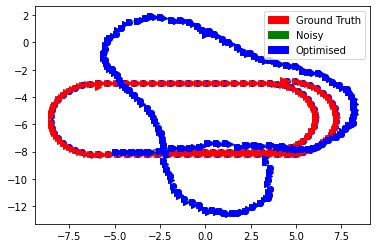

Iteration = 1, Error = 220909.75
Iteration = 2, Error = 4589.806640625
Iteration = 3, Error = 6217.81005859375
Iteration = 4, Error = 7710.302734375
Iteration = 5, Error = 13792.7373046875
Iteration = 6, Error = 22070.5703125
Iteration = 7, Error = 11924.9560546875
Iteration = 8, Error = 1082.8485107421875
Iteration = 9, Error = 379.3211669921875
Iteration = 10, Error = 268.4075012207031


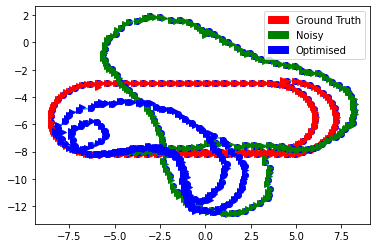

Iteration = 11, Error = 221.03529357910156
Iteration = 12, Error = 291.66290283203125
Iteration = 13, Error = 545.9425048828125
Iteration = 14, Error = 956.3168334960938
Iteration = 15, Error = 791.3893432617188
Iteration = 16, Error = 280.2378845214844
Iteration = 17, Error = 470.2901611328125
Iteration = 18, Error = 775.1582641601562
Iteration = 19, Error = 383.0627746582031
Iteration = 20, Error = 186.22671508789062


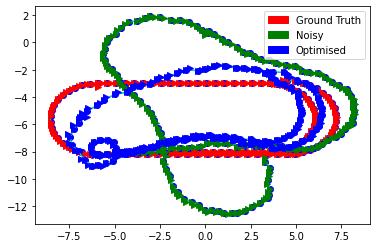

Iteration = 21, Error = 274.5375061035156
Iteration = 22, Error = 624.0474853515625
Iteration = 23, Error = 1143.110595703125
Iteration = 24, Error = 1573.3397216796875
Iteration = 25, Error = 1460.6632080078125
Iteration = 26, Error = 623.6832275390625
Iteration = 27, Error = 816.3095703125
Iteration = 28, Error = 3744.3017578125
Iteration = 29, Error = 3097.750244140625
Iteration = 30, Error = 763.3529663085938


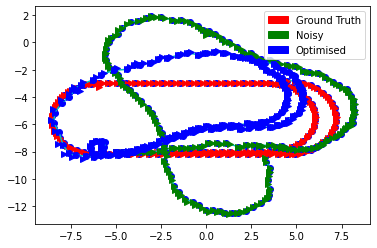

Iteration = 31, Error = 252.55752563476562
Iteration = 32, Error = 611.5772705078125
Iteration = 33, Error = 1934.533447265625
Iteration = 34, Error = 4943.48876953125
Iteration = 35, Error = 10924.3544921875
Iteration = 36, Error = 18739.896484375
Iteration = 37, Error = 16390.82421875
Iteration = 38, Error = 5497.10107421875
Iteration = 39, Error = 2025.6749267578125
Iteration = 40, Error = 3426.80810546875


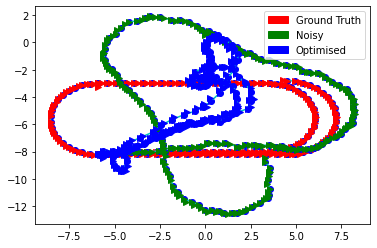

Iteration = 41, Error = 4104.193359375
Iteration = 42, Error = 4304.29541015625
Iteration = 43, Error = 3463.595458984375
Iteration = 44, Error = 1306.9384765625
Iteration = 45, Error = 6066.05029296875
Iteration = 46, Error = 8130.5263671875
Iteration = 47, Error = 7561.86669921875
Iteration = 48, Error = 5881.61083984375
Iteration = 49, Error = 3582.7802734375
Iteration = 50, Error = 1744.06640625


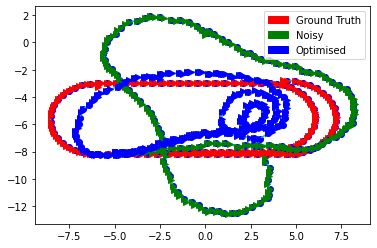

Iteration = 51, Error = 726.0110473632812
Iteration = 52, Error = 332.31756591796875
Iteration = 53, Error = 217.16888427734375
Iteration = 54, Error = 186.42543029785156
Iteration = 55, Error = 177.1878662109375
Iteration = 56, Error = 173.50750732421875
Iteration = 57, Error = 171.56178283691406
Iteration = 58, Error = 170.3748321533203
Iteration = 59, Error = 169.6200408935547
Iteration = 60, Error = 169.1378936767578


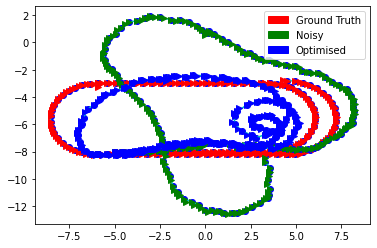

Iteration = 61, Error = 168.83111572265625
Iteration = 62, Error = 168.63619995117188
Iteration = 63, Error = 168.51266479492188
Iteration = 64, Error = 168.4342803955078
Iteration = 65, Error = 168.38453674316406
Iteration = 66, Error = 168.35296630859375
Iteration = 67, Error = 168.33287048339844
Iteration = 68, Error = 168.3200225830078
Iteration = 69, Error = 168.311767578125
Iteration = 70, Error = 168.30641174316406


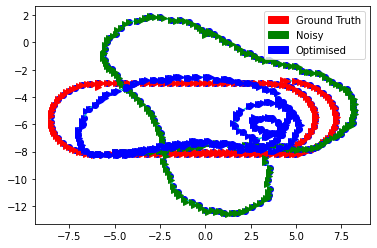

Iteration = 71, Error = 168.30303955078125
Iteration = 72, Error = 168.30081176757812
Iteration = 73, Error = 168.29937744140625
Iteration = 74, Error = 168.2983856201172
Iteration = 75, Error = 168.29769897460938
Iteration = 76, Error = 168.29727172851562
Iteration = 77, Error = 168.2969512939453
Iteration = 78, Error = 168.29672241210938
Iteration = 79, Error = 168.2965545654297
Iteration = 80, Error = 168.29647827148438


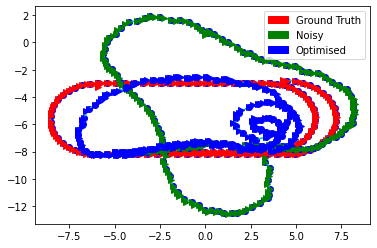

Iteration = 81, Error = 168.29640197753906
Iteration = 82, Error = 168.2963409423828
Iteration = 83, Error = 168.29632568359375
Iteration = 84, Error = 168.2962646484375
Iteration = 85, Error = 168.29624938964844
Iteration = 86, Error = 168.29624938964844
Iteration = 87, Error = 168.2961883544922
Iteration = 88, Error = 168.29627990722656
Iteration = 89, Error = 168.29623413085938
Iteration = 90, Error = 168.2962188720703


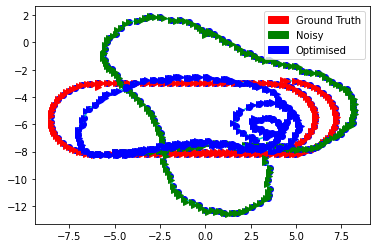

Iteration = 91, Error = 168.2962188720703
Iteration = 92, Error = 168.2962188720703
Iteration = 93, Error = 168.29620361328125
Iteration = 94, Error = 168.2961883544922
Iteration = 95, Error = 168.2961883544922
Iteration = 96, Error = 168.29620361328125
Iteration = 97, Error = 168.29615783691406
Iteration = 98, Error = 168.2961883544922
Iteration = 99, Error = 168.2961883544922


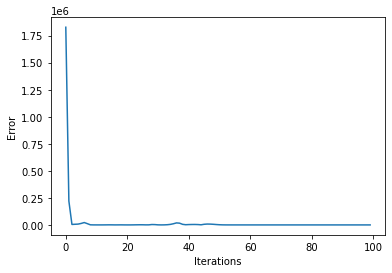

Finally


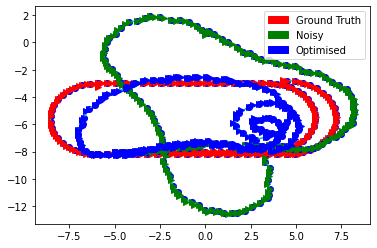

In [32]:
poses_opt = Levenberg_Marquardt(edges, edges_lc, poses, prior, 100, 1, infos = [100, 2000, 3000], plot_error = True)

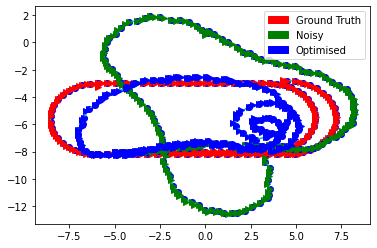

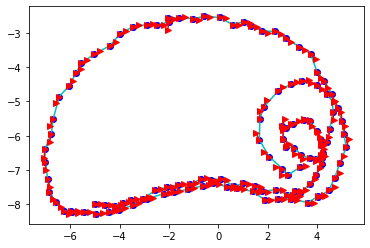

In [33]:
draw_together(poses_gt, poses, poses_opt)
draw(poses_opt[:, 0], poses_opt[:, 1], poses_opt[:, 2])

Iteration = 0, Error = 1826777.25


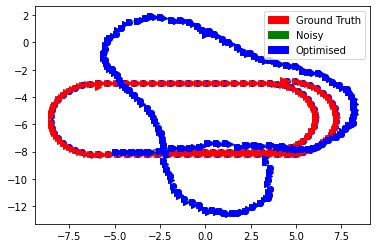

Iteration = 1, Error = 320287.78125
Iteration = 2, Error = 18097.982421875
Iteration = 3, Error = 10023.4853515625
Iteration = 4, Error = 5299.9912109375
Iteration = 5, Error = 483.4613342285156
Iteration = 6, Error = 2285.40087890625
Iteration = 7, Error = 15398.1943359375
Iteration = 8, Error = 21445.171875
Iteration = 9, Error = 38974.4765625
Iteration = 10, Error = 68011.140625


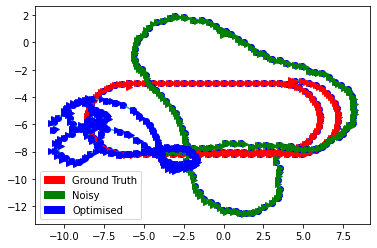

Iteration = 11, Error = 10882.3818359375
Iteration = 12, Error = 282.1924133300781
Iteration = 13, Error = 68.07921600341797
Iteration = 14, Error = 112.27198028564453
Iteration = 15, Error = 121.02335357666016
Iteration = 16, Error = 27.736690521240234
Iteration = 17, Error = 42.11928176879883
Iteration = 18, Error = 134.87242126464844
Iteration = 19, Error = 139.5673370361328
Iteration = 20, Error = 56.23674011230469


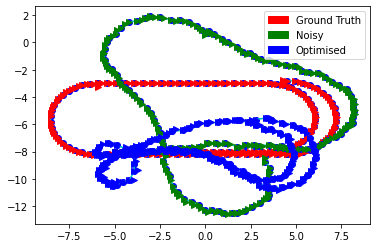

Iteration = 21, Error = 25.862625122070312
Iteration = 22, Error = 85.17596435546875
Iteration = 23, Error = 130.62843322753906
Iteration = 24, Error = 49.041297912597656
Iteration = 25, Error = 19.962167739868164
Iteration = 26, Error = 33.65679931640625
Iteration = 27, Error = 144.364501953125
Iteration = 28, Error = 284.887451171875
Iteration = 29, Error = 336.4402160644531
Iteration = 30, Error = 277.45733642578125


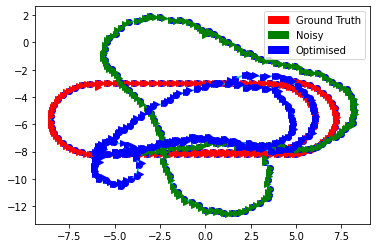

Iteration = 31, Error = 156.98291015625
Iteration = 32, Error = 39.1309928894043
Iteration = 33, Error = 140.53225708007812
Iteration = 34, Error = 658.2335205078125
Iteration = 35, Error = 481.287841796875
Iteration = 36, Error = 76.1014175415039
Iteration = 37, Error = 58.738372802734375
Iteration = 38, Error = 358.23358154296875
Iteration = 39, Error = 1094.64892578125
Iteration = 40, Error = 2212.591796875


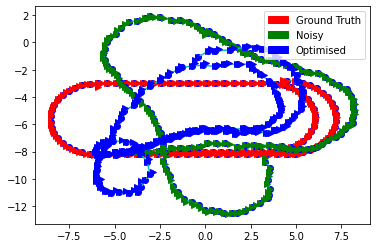

Iteration = 41, Error = 3323.142578125
Iteration = 42, Error = 3136.212646484375
Iteration = 43, Error = 916.3019409179688
Iteration = 44, Error = 1423.8486328125
Iteration = 45, Error = 7506.8798828125
Iteration = 46, Error = 7903.2861328125
Iteration = 47, Error = 2031.380615234375
Iteration = 48, Error = 102.37733459472656
Iteration = 49, Error = 206.71588134765625
Iteration = 50, Error = 1109.2825927734375


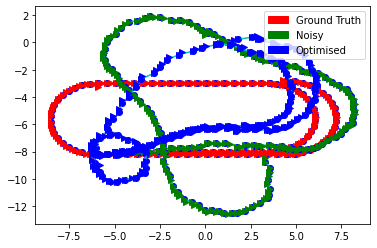

Iteration = 51, Error = 3849.4404296875
Iteration = 52, Error = 10661.875
Iteration = 53, Error = 25637.6796875
Iteration = 54, Error = 33154.7578125
Iteration = 55, Error = 7400.57080078125
Iteration = 56, Error = 373.83953857421875
Iteration = 57, Error = 234.7622833251953
Iteration = 58, Error = 1001.3078002929688
Iteration = 59, Error = 735.4986572265625
Iteration = 60, Error = 5976.51953125


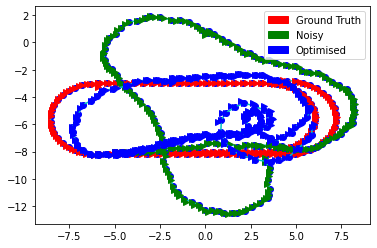

Iteration = 61, Error = 8533.310546875
Iteration = 62, Error = 5841.07568359375
Iteration = 63, Error = 3439.435302734375
Iteration = 64, Error = 1097.6480712890625
Iteration = 65, Error = 238.74603271484375
Iteration = 66, Error = 60.559593200683594
Iteration = 67, Error = 28.178348541259766
Iteration = 68, Error = 21.188268661499023
Iteration = 69, Error = 19.146535873413086
Iteration = 70, Error = 18.227828979492188


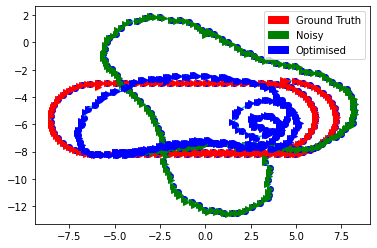

Iteration = 71, Error = 17.73157501220703
Iteration = 72, Error = 17.426013946533203
Iteration = 73, Error = 17.24100685119629
Iteration = 74, Error = 17.127416610717773
Iteration = 75, Error = 17.05739974975586
Iteration = 76, Error = 17.014005661010742
Iteration = 77, Error = 16.98692512512207
Iteration = 78, Error = 16.970035552978516
Iteration = 79, Error = 16.95942497253418
Iteration = 80, Error = 16.95277214050293


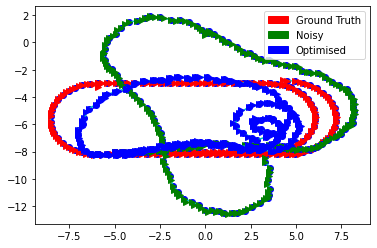

Iteration = 81, Error = 16.948606491088867
Iteration = 82, Error = 16.946001052856445
Iteration = 83, Error = 16.944347381591797
Iteration = 84, Error = 16.94330406188965
Iteration = 85, Error = 16.942644119262695
Iteration = 86, Error = 16.942224502563477
Iteration = 87, Error = 16.941951751708984
Iteration = 88, Error = 16.94178581237793
Iteration = 89, Error = 16.941675186157227
Iteration = 90, Error = 16.94160270690918


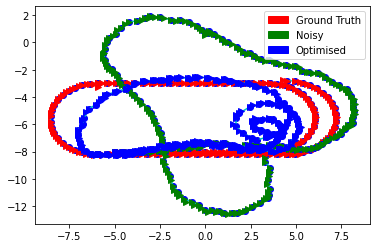

Iteration = 91, Error = 16.941553115844727
Iteration = 92, Error = 16.941530227661133
Iteration = 93, Error = 16.941503524780273
Iteration = 94, Error = 16.941492080688477
Iteration = 95, Error = 16.941476821899414
Iteration = 96, Error = 16.941476821899414
Iteration = 97, Error = 16.941469192504883
Iteration = 98, Error = 16.941463470458984
Iteration = 99, Error = 16.941465377807617


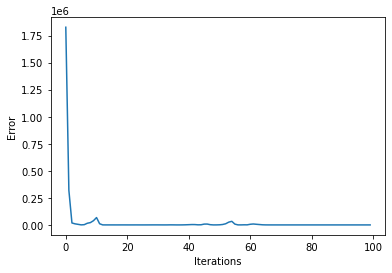

Finally


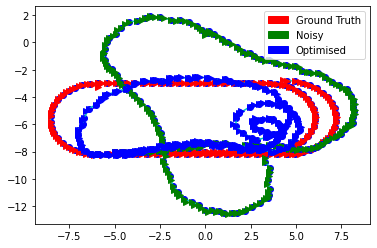

In [34]:
poses_opt = Levenberg_Marquardt(edges, edges_lc, poses, prior, 100, 1, infos = [10, 2000, 10000], plot_error = True)

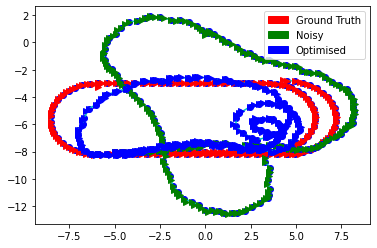

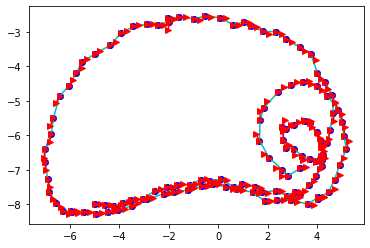

In [35]:
draw_together(poses_gt, poses, poses_opt)
draw(poses_opt[:, 0], poses_opt[:, 1], poses_opt[:, 2])

## Part 3

#### - Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 


**Residuals:** </br>
Let the motion model be,

$$ f\left(\mathbf{x}_{k}, \mathbf {\Delta x_{(k,j)}}\right) = x_{j} = x_{k} + \Delta x_{(k,j)} \cos(\theta_k) - \Delta y_{(k,j)} \sin(\theta_k) \\
f\left(\mathbf{y}_{k}, \mathbf {\Delta y_{(k,j)}}\right) = y_{j} = y_{k} + \Delta y_{(k,j)} \cos(\theta_k) + \Delta x_{(k,j)} \sin(\theta_k) \\
f\left(\mathbf{theta}_{k}, \mathbf {\Delta theta_{(k,j)}}\right) =  \theta_{j} = \theta_{k}+  \Delta \theta_{(k,j)} $$
</br>
The Residual is given by,

$$ residual =\left[\begin{array}{c}
f\left(\mathbf{x}_{0}, \mathbf {\Delta x_{(0,1)}}\right)-\mathbf{x}_{1} \\
f\left(\mathbf{y}_{0}, \mathbf {\Delta y_{(0,1)}}\right)-\mathbf{y}_{1} \\
f\left(\mathbf{theta}_{0}, \mathbf {\Delta theta_{(0,1)}}\right)-\mathbf{theta}_{1} \\
f\left(\mathbf{x}_{1}, \mathbf {\Delta x_{(1,2)}}\right)-\mathbf{x}_{2} \\
f\left(\mathbf{y}_{1}, \mathbf {\Delta y_{(1,2)}}\right)-\mathbf{y}_{2} \\
f\left(\mathbf{theta}_{1}, \mathbf {\Delta theta_{(1,2)}}\right)-\mathbf{theta}_{2} \\
\vdots \\
f\left(\mathbf{x}_{0}, \mathbf {\Delta x_{(0,80)}}\right)-\mathbf{x}_{80} \\
f\left(\mathbf{y}_{0}, \mathbf {\Delta y_{(0,80)}}\right)-\mathbf{y}_{80} \\
f\left(\mathbf{theta}_{0}, \mathbf {\Delta theta_{(0,80)}}\right)-\mathbf{theta}_{80} \\
\vdots \\
\\\mathbf{x}_{0}-\mathbf{prior(x)}
\\\mathbf{y}_{0}-\mathbf{prior(y)}
\\\mathbf{theta}_{0}-\mathbf{prior(theta)}
\end{array}\right]_{\mathbf{420 x 1}}$$

The Shape of the residual is (m+n+1)* N x 1.</br>
where m is no. of poses(vertices), 1 prior , hence (m+1) poses</br>
n is no. of loop closure constraints, N is no. of variables. 

**Jacobian:** </br>

The jacobian of residual(k,j) w.r.t. a pose k is ,
                            
$$ \mathbf{J_{s(k,j)}} =  \left[\begin{array}{ccc}
1 & 0 & -\Delta x_{(k,j)} \sin(\theta_k) - \Delta y_{(k,j)} \cos(\theta_k) \\
0 & 1 & -\Delta y_{(k,j)} \sin(\theta_k) + \Delta x_{(k,j)} \cos(\theta_k) \\
0 & 0 & 1 \\
\end{array}\right]$$
</br>
Also the jacobian of the same residual w.r.t. pose j is,
$$ \mathbf{J_{n(k,j)}} =  \left[\begin{array}{ccc}
-1 & 0 & 0 \\
0 & -1 & 0 \\
0 & 0 & -1 \\
\end{array}\right]$$
</br>
The Jocabian is given by,

$$ \mathbf{J} =\left[\begin{array}{ccccccc}
\mathbf{J_{s(0,1)}} & \mathbf{J_{n(0,1)}} & 0 & \dots & \dots & \dots & \vdots & 0 \\
0 & \mathbf{J_{s(1,2)}}& \mathbf{J_{n(1,2)}} & 0 & \dots & \dots & \vdots & 0 \\
0 & 0 & \mathbf{J_{s(2,3)}}& \mathbf{J_{n(2,3)}} & 0 & \dots & \vdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \ddots & \vdots & \vdots & \vdots   \\
\vdots & \vdots & \vdots & \vdots & \ddots & \ddots & \vdots & \vdots   \\
\mathbf{J_{s(0,80)}} & 0 & \dots & \dots & \mathbf{J_{n(0,80)}} & 0 & \dots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots   \\
\left[\begin{array}{ccc}
1 & 0 & 0\\ 
0 & 1 & 0\\
0 & 0 & 1\\
\end{array}\right] & \dots & \dots & \dots & \dots & \dots  & \dots & 0 \\
\end{array}\right]_{\mathbf{420x360}}$$

The Shape of the jacobian is (m+n+1) * N x (m+1) * N,</br>
where m is no. of poses(vertices), 1 prior , hence (m+1) poses</br>
n is no. of loop closure constraints, N is no. of variables. 

Shape in our case is 420 by 360.

The Jacobian matrix is sparse in nature, only filled for 2 * N entries per row (except last N rows, which represent prior). We can also observe that the columns filled represent the edges between poses (both normal and loop closure).


#### - Write about the optimization process and any observations using intermediate plots and such. 

Optimization is done with help of Levenberg-Marquardt algorithm.</br>
The process is as follows:

Step-1 : Find the poses with the help of motion model, prior, odometry of edges and loop closure constraints.</br>
Step-2 : Calculate the Jacobian(J).</br>
Step-3 : Calculate the Information Matrix($\Omega$) with covariances of odometry edges, loop closure constraints and prior.</br>
Step-4 : Calculate the Residual(f) with help of poses and edges.</br>
Step-5 : Calculate error with residual and information matrix [$ error = f^T*\Omega*f$] .</br>
Step-6 : Now, calculate $\Delta = -(J^T*\Omega*J + \lambda * I)^{-1} * (J^T*\Omega*f)$. </br> 
Step-7 : This $\Delta$ is now added to the poses matrix. </br>
Step-8 : Repeat from Step-4 until the error is less than the tolerance. </br>



The Observations for this optimization can be observed from the below link.</br>
[Here](#Optimization)

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [36]:
save_g2o_from_edges_init("../data/edges.txt","../data/optimised_traj.g2o", poses_opt)